# k-means Clustering with RFM-Data

...


### Data Sources
- `data/interim/rfm_data.csv`: Transformed data from nb 1. A customer-level dataset wit recency, frequency, and monetary value columns.


### Changes

- 2019-02-19: Start notebook
- 

---

### Import libraries, load data

In [1]:
# Load libraries
import numpy as np
import pandas as pd
from tqdm import tqdm
import datetime as dt

from sklearn.preprocessing import minmax_scale, StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

# My functions
import EDA_functions as EDA
import cleaning_functions as cleaning

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
# sns.set_style('whitegrid')
color = 'rebeccapurple'
%matplotlib inline

# Display settings
from IPython.display import display
pd.options.display.max_columns = 100

In [2]:
# Import data
rfm_data = pd.read_csv('data/interim/rfm_data.csv', index_col = 0, )

## 1) Preprocess Data

In [3]:
rfm_data.head()

,sales,frequency,recency,flag
CustomerID,,,,
18102,233736.93,57,1,high
17450,192521.95,44,9,high
16446,168472.50,2,1,high
17511,87591.70,29,3,high
12346,77183.60,1,326,high


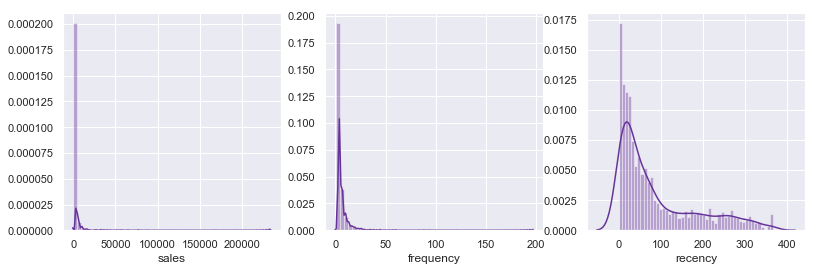

In [4]:
EDA.plot_num_hist(rfm_data, figsize=(18, 4))

**Observations:** Data is right-skewed and contains outliers

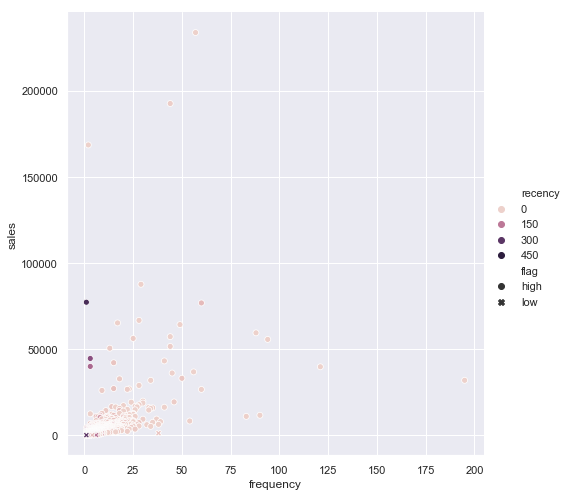

In [5]:
sns.relplot('frequency', 'sales', data=rfm_data, style='flag', hue='recency', height=7);

**Observation:** Not much to be seen apart from outliers. Big bulk of customers buys up to 25 times a year and generates sales of less than 25'000.

### Log-transform & Scale

k-means clustering requires continuous variables and works best with relatively normally-distributed, standardized input variables. Standardizing the input variables is quite important; otherwise, input variables with larger variances will have commensurately greater influence on the results.

In [6]:
# Log-transform
rfm_log = cleaning.apply_log(rfm_data, cols_to_transform=['frequency', 'recency', 'sales'], rename=True)

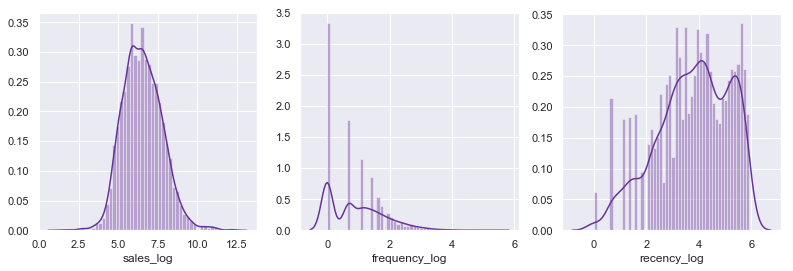

In [7]:
EDA.plot_num_hist(rfm_log, figsize=(18, 4))

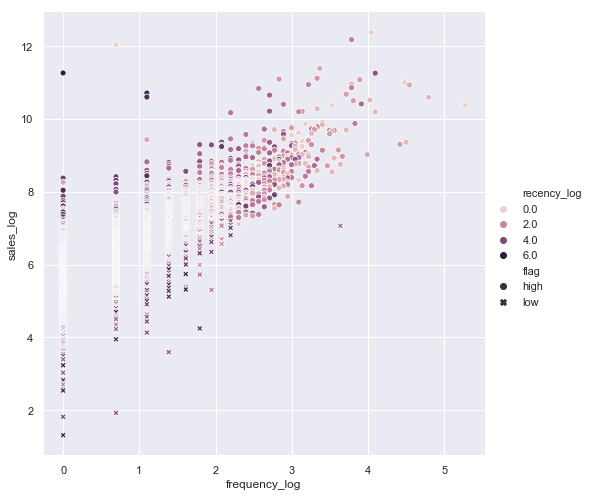

In [8]:
sns.relplot('frequency_log', 'sales_log', data=rfm_log, style='flag', hue='recency_log', height=7);

**Observation:** The data points are fairly continuously-distributed. There aren’t clear clusters. This means that any cluster groupings we create won’t exactly reflect some true, underlying group membership – they’ll be somewhat arbitrary (albeit reasonable) distinctions that we draw for our own purposes.

#### Note on Outlier-Handling

k-means clustering tends to be sensitive to outliers, such that outliers will sometimes end up being clustered together in their own tiny group. This is often cited as a reason to exclude them from the analysis. _In this type of customer segmentation, however, the outliers may be the most important customers to understand._ 

- In the top, right-hand corner, we have customers who are outliers in terms of being extraordinarily high-value, high-frequency shoppers. These data points are all represented with little triangles, indicating that they’re in the top 80/20 category. These are important customers to understand, because they’re the customers we most want. 
- At the other end of the continuum, we have the no-value customers in the bottom, left-hand corner. These customers, too, may be important to model and understand – they’re the customers we want to minimize. 

These outliers are deliberatly included in the analysis.

In [9]:
# # Scale data to range (0,1)
# rfm_log_scaled = minmax_scale(rfm_log[['sales_log', 'frequency_log', 'recency_log']])
# rfm_log_scaled = pd.DataFrame(rfm_log_scaled, columns=rfm_data.columns[:3])

In [10]:
# Scale data with StandardScaler
scaler = StandardScaler()
rfm_log_scaled = scaler.fit_transform(rfm_log[['sales_log', 'frequency_log', 'recency_log']])
rfm_log_scaled = pd.DataFrame(rfm_log_scaled, columns=rfm_log.columns[:3])

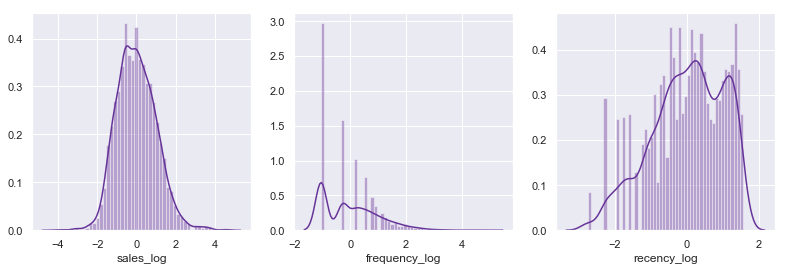

In [11]:
EDA.plot_num_hist(rfm_log_scaled, figsize=(18, 4))

#### Note on Scaling

I ran k-means both scaling with MinMaxScaling and StandardScaler, the overalll results looked more or less (but not totally) the same. For a real-life project I would experiment with different kinds of pre-processing (see [starbucks segmentation challenge repository](https://github.com/rbuerki/segmentation-challenge-starbucks)).

## 3) Apply k-means Clustering

### Evaluate Number of Clusters (high-level)

In [12]:
# Evaluate number of clusters with silhouette score

def print_silhouette_kmeans(df, cluster_range):
    """Print silhouette scores for k-means clustering with sklearn.
    
    Arguments:
    ----------
    - df: dataframe, containing the presumed clusters
    - cluster_range: list of integers, desired number of clusters
    
    Returns:
    --------
    - sil_scores: dict, containing the number of clusters and corresponding
        silhouette scores
    """
    
    sil_scores = {}

    for nc in cluster_range:
        kmeans = KMeans(n_clusters=nc)   
        kmeans.fit(df)

        # predict the cluster for each data point
        preds = kmeans.predict(df)
        # calculate the mean silhouette coefficient for the number of clusters chosen
        score = silhouette_score(df, preds)
        # append to dict
        sil_scores[nc] = score

    return sil_scores

In [13]:
# Call function for defined cluster range
cluster_range = range(2, 11)
sil_scores = print_silhouette_kmeans(rfm_log_scaled, cluster_range=cluster_range)

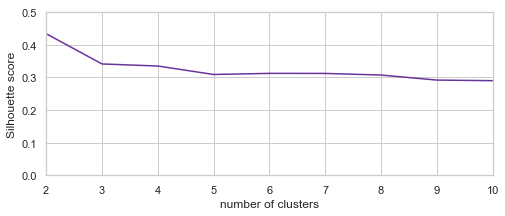

In [14]:
# Print results
sil_scores = pd.Series(list(sil_scores.values()), index=list(sil_scores.keys()))
plt.figure(figsize=(8,3))
sns.set_style("whitegrid")
sns.lineplot(data=sil_scores, color=color)
plt.xlabel("number of clusters")
plt.ylabel("Silhouette score")
plt.xticks(np.arange(0, 11, step=1))
plt.xlim(2, 10)
plt.ylim(0, 0.5);

**Observation:** Silhouette score is pretty constant, I would settle for 3 to 5 segments.

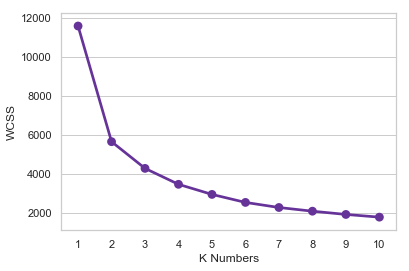

In [15]:
# Evaluate the number of clusters with the Elbow method
wcss = {}
for k in range(1, 11):
    kmeans = KMeans(n_clusters= k, init= 'k-means++', max_iter= 300)
    kmeans.fit(rfm_log_scaled)
    wcss[k] = kmeans.inertia_

# Plot the WCSS values
sns.pointplot(x = list(wcss.keys()), y = list(wcss.values()), color=color)
plt.xlabel('K Numbers')
plt.ylabel('WCSS')
plt.show()

**Observation:** Looking at WCSS only we would go for 3-4 clusters.

#### Note on n-cluster selection

At this juncture, it makes sense to show interested stakeholders the cluster solutions and get their input. The decision should be based upon how the business plans to use the results, and the level of granularity they want to see in the clusters.

### Analyze possible cluster configurations in more detail

In [16]:
# Visualize Clusters for range 3-6

def visualize_clusters(df, x_col, y_col, cluster_range, figsize=(16, 16), palette='rocket'):
    """Visualize clusters on scatterplot for k-means clustering with sklearn.
    
    Arguments:
    ----------
    - df: dataframe, containing the presumed clusters
    - x_col: string, column label for data to plot on x-axis
    - y_col: string, column label for data to plot on y-axis
    - cluster_range: list of integers, desired number of clusters
    - figsize: tuple (default=(16, 16))
    - palette: string (default='rocket')
    
    Returns:
    --------
    - None. Outputs a series of scatterplots for the desired cluster range.
    """
    
    df = df.copy
    position=0
    plt.figure(figsize=figsize)

    for nc in cluster_range:
        kmeans = KMeans(n_clusters=nc)   
        kmeans.fit(df)

        # Assign the clusters to df
        df['K_Cluster'] = kmeans.labels_
        df['K_Cluster'] = df['K_Cluster'].astype('category')
        print("\nn_clusters:", nc)
        print(df['K_Cluster'].value_counts() / len(df))
        
        position +=1
        plt.subplot(np.rint((len(cluster_range)/2) + 0.1), 2 , position)
        sns.scatterplot(x=x_col, y=y_col, hue='K_Cluster', data=df,
                        edgecolor=None, palette=palette, legend='full');  # set edgecolor=None for better visibility


n_clusters: 3
2    0.419990
0    0.403936
1    0.176075
Name: K_Cluster, dtype: float64

n_clusters: 4
0    0.419990
1    0.261523
2    0.175816
3    0.142672
Name: K_Cluster, dtype: float64

n_clusters: 5
4    0.261523
1    0.252460
0    0.175816
2    0.167530
3    0.142672
Name: K_Cluster, dtype: float64

n_clusters: 6
2    0.261523
4    0.252460
0    0.167530
3    0.142672
1    0.131020
5    0.044795
Name: K_Cluster, dtype: float64


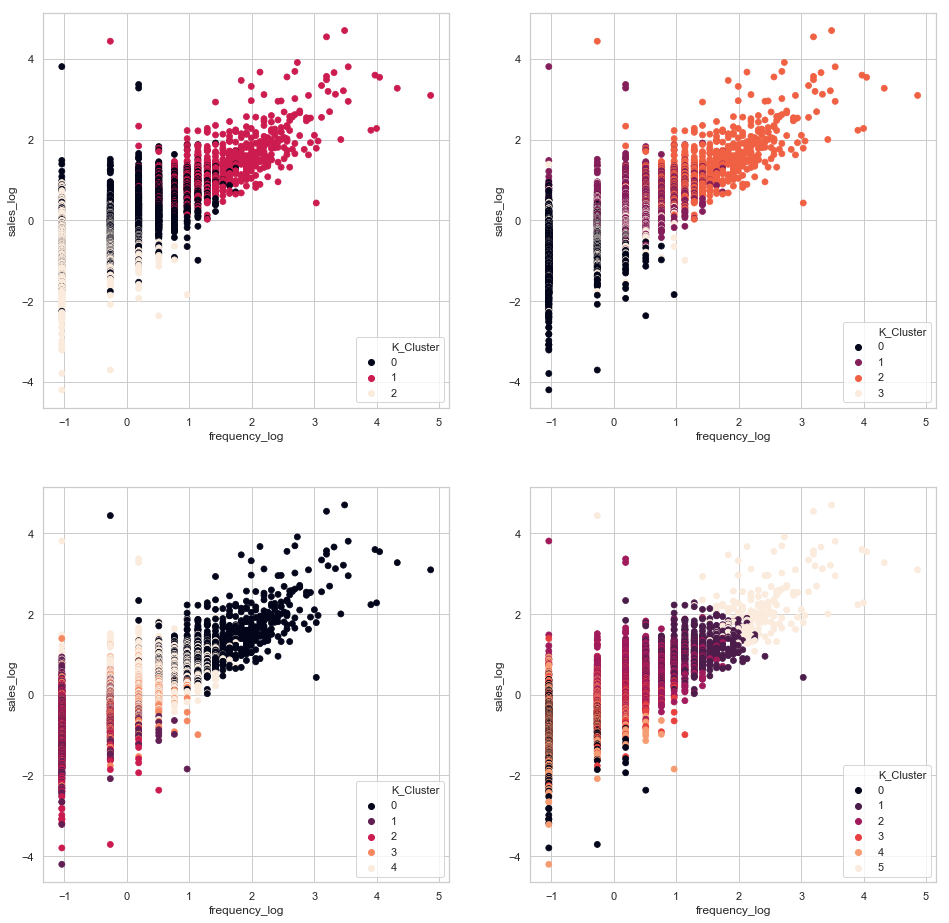

In [19]:
cluster_range = range(3, 7)
visualize_clusters(rfm_log_scaled, 'frequency_log', 'sales_log', 
                   cluster_range, figsize=(16, 16), palette='rocket')

**Observations:**
- Difference between 3 an 4 clusters is that the large 'middle' cluster is further broken up in two groups (maybe due to recency, let's check that further below)
- Difference between 4 and 5 clusters is that the large 'worst' cluster is further broken up in two groups (maybe due to recency, let's check that further below)
- Difference between 5 and 6 clusters is that the 'best' cluster is further broken up in two groups, with the very best 4.5% of customers forming their own segment.

In [20]:
kmeans = KMeans(n_clusters=3)   
kmeans.fit(rfm_log_scaled)
kmeans.cluster_centers_

array([[ 6.28730269e-01,  6.61956798e-01, -5.28982099e-01,
         2.22515025e+00],
       [-8.43610814e-01, -9.16675978e-01,  9.81471760e-02,
         1.42108547e-14],
       [-7.73885337e-01, -7.97265396e-01,  1.02726906e+00,
         3.92680608e+00]])

In [21]:
rfm_log_scaled

,sales_log,frequency_log,recency_log,K_Cluster
0,4.700606,3.487355,-2.754174,5
1,4.544186,3.197337,-1.147684,5
2,4.436590,-0.265745,-2.754174,5
3,3.909172,2.730266,-1.950929,5
4,3.807170,-1.042320,1.476888,2
5,3.802662,3.544822,-0.075579,5
6,3.688896,2.690951,-1.577441,5
7,3.670682,2.131901,-1.577441,5
8,3.658623,3.317922,-1.740592,5
9,3.596214,3.973912,-2.754174,5


In [18]:

# TODO: Find the cluster centers
centers = kmeans.cluster_centers_ 


# TODO: Inverse transform the centers
log_centers = pca.inverse_transform(centers)

# TODO: Exponentiate the centers
true_centers = np.exp(log_centers)

NameError: name 'pca' is not defined